# List of todos/questions


- Custom regularization on non-driver features?
- Interaction terms?
- Finished (what if they didn't finish?) we still have placement for them
- Finishing position or relative finishing position?


- There's no way to validate the usefulness of this until we through it into the predictive model

In [57]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
# prompt: connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
#  Check TensorFlow version
print(tf.__version__)

# Check available devices
print("Available devices:", tf.config.list_physical_devices())

# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

# with tf.device('/gpu:0')

2.14.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0


## Read all the data

In [4]:
def load_kaggle_data(path):
    data = pd.read_csv(path)
    data.replace({'\\N':np.nan}, inplace=True)
    return data

data_dir ='/content/drive/MyDrive/Northwestern/Fall2023-Machine_learning/Project_machine_learning/Formula1/'

circuits_raw_df = load_kaggle_data(f'{data_dir}/circuits.csv')
constructors_raw_df = load_kaggle_data(f'{data_dir}/constructors.csv')
constructor_standings_raw_df = load_kaggle_data(f'{data_dir}/constructor_standings.csv')
driver_standings_raw_df = load_kaggle_data(f'{data_dir}/driver_standings.csv')
drivers_raw_df = load_kaggle_data(f'{data_dir}/drivers.csv')
laptimes_raw_df = load_kaggle_data(f'{data_dir}/lap_times.csv')
pitstops_raw_df = load_kaggle_data(f'{data_dir}/pit_stops.csv')
qualifying_raw_df = load_kaggle_data(f'{data_dir}/qualifying.csv')
races_raw_df = load_kaggle_data(f'{data_dir}/races.csv')
results_raw_df = load_kaggle_data(f'{data_dir}/results.csv')
seasons_raw_df = load_kaggle_data(f'{data_dir}/seasons.csv')
sprint_results = load_kaggle_data(f'{data_dir}/sprint_results.csv')
status_raw_df = load_kaggle_data(f'{data_dir}/status.csv')

print('circuits_raw_df', circuits_raw_df.columns)
print('constructors_raw_df', constructors_raw_df.columns)
print('constructor_standings_raw_df', constructor_standings_raw_df.columns)
print('driver_standings_raw_df', driver_standings_raw_df.columns)
print('drivers_raw_df', drivers_raw_df.columns)
print('laptimes_raw_df', laptimes_raw_df.columns)
print('pitstops_raw_df', pitstops_raw_df.columns)
print('qualifying_raw_df', qualifying_raw_df.columns)
print('races_raw_df', races_raw_df.columns)
print('results_raw_df', results_raw_df.columns)
print('seasons_raw_df', seasons_raw_df.columns)
print('sprint_results', sprint_results.columns)
print('status_raw_df', status_raw_df.columns)

circuits_raw_df Index(['circuitId', 'circuitRef', 'name', 'location', 'country', 'lat', 'lng',
       'alt', 'url'],
      dtype='object')
constructors_raw_df Index(['constructorId', 'constructorRef', 'name', 'nationality', 'url'], dtype='object')
constructor_standings_raw_df Index(['constructorStandingsId', 'raceId', 'constructorId', 'points',
       'position', 'positionText', 'wins'],
      dtype='object')
driver_standings_raw_df Index(['driverStandingsId', 'raceId', 'driverId', 'points', 'position',
       'positionText', 'wins'],
      dtype='object')
drivers_raw_df Index(['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob',
       'nationality', 'url'],
      dtype='object')
laptimes_raw_df Index(['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds'], dtype='object')
pitstops_raw_df Index(['raceId', 'driverId', 'stop', 'lap', 'time', 'duration',
       'milliseconds'],
      dtype='object')
qualifying_raw_df Index(['qualifyId', 'raceId', 'driverId',

In [5]:
races_raw_df.shape

(1101, 18)

In [6]:
races_raw_df.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
races_raw_df[races_raw_df["raceId"] == 841]

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
839,841,2011,1,1,Australian Grand Prix,2011-03-27,06:00:00,http://en.wikipedia.org/wiki/2011_Australian_G...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
results_df2 = results_raw_df.copy()

In [9]:
drivers_raw_df.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,NaN,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,NaN,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [10]:
drivers_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   driverId     857 non-null    int64 
 1   driverRef    857 non-null    object
 2   number       54 non-null     object
 3   code         100 non-null    object
 4   forename     857 non-null    object
 5   surname      857 non-null    object
 6   dob          857 non-null    object
 7   nationality  857 non-null    object
 8   url          857 non-null    object
dtypes: int64(1), object(8)
memory usage: 60.4+ KB


In [11]:
drivers_raw_df.columns

Index(['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob',
       'nationality', 'url'],
      dtype='object')

In [12]:
# Get driver name data
drivers = drivers_raw_df[['driverId','forename','surname','number']].reset_index(drop=True)
drivers['Name'] = drivers[['forename', 'surname']].agg(' '.join, axis=1)
drivers.drop(['forename','surname'], axis=1, inplace=True)

driver_name_id_map = dict(zip(drivers['Name'], drivers['driverId']))
def get_driverID(name):

    return drivers.loc[drivers['Name']==name, 'driverId'].squeeze()

driver_name_number_map = dict(zip(drivers['Name'], drivers['number']))
def get_driver_number(name):

    return drivers.loc[drivers['Name']==name, 'number'].squeeze()


#drivers[drivers['Name'].str.contains('Nyck')]

driver_names_of_interest = ['Max Verstappen',
                           'Sergio Pérez',
                           'Lewis Hamilton',
                           'Fernando Alonso',
                           'Charles Leclerc',
                           'Lando Norris',
                           'George Russell',
                           'Oscar Piastri',
                           'Lance Stroll',
                           'Pierre Gasly',
                           'Esteban Ocon',
                           'Alexander Albon',
                           'Nico Hülkenberg',
                           'Valtteri Bottas',
                           'Guanyu Zhou',
                           'Yuki Tsunoda',
                           'Kevin Magnussen',
                           #'Liam Lawson',
                           'Logan Sargeant',
                           'Nyck de Vries',
                           'Daniel Ricciardo']
driver_ids_of_interest = [driver_name_id_map[name] for name in driver_names_of_interest]
driver_numbers_of_interest = [driver_name_number_map[name] for name in driver_names_of_interest]

In [13]:
print(driver_numbers_of_interest), len(driver_numbers_of_interest)

['33', '11', '44', '14', '16', '4', '63', '81', '18', '10', '31', '23', '27', '77', '24', '22', '20', '2', '21', '3']


(None, 20)

In [14]:
laptimes_raw_df

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342
...,...,...,...,...,...,...
551737,1110,817,40,17,1:54.361,114361
551738,1110,817,41,17,1:53.367,113367
551739,1110,817,42,16,1:55.247,115247
551740,1110,817,43,16,1:52.115,112115


In [15]:
# Check for changing positions for each driver each race
laptimes_raw_df.groupby(["driverId", "raceId"])["position"].value_counts()

driverId  raceId  position
1         1       10          13
                  8            9
                  9            8
                  12           6
                  15           6
                              ..
858       1110    15           2
                  10           1
                  12           1
                  13           1
                  14           1
Name: position, Length: 64508, dtype: int64

In [16]:
# Position present after each lap
race1 = laptimes_raw_df[laptimes_raw_df["raceId"] == 841]
race2 = race1[race1["driverId"] == 20]
race2.position.value_counts()

1    55
3     1
4     1
2     1
Name: position, dtype: int64

In [17]:
laptimes_raw_df.describe()

,raceId,driverId,lap,position,milliseconds
count,551742.000000,551742.000000,551742.000000,551742.000000,5.517420e+05
mean,564.878467,296.918785,29.990193,9.658699,9.570621e+04
std,425.883069,377.935897,18.420399,5.538011,7.478605e+04
min,1.000000,1.000000,1.000000,1.000000,5.540400e+04
25%,131.000000,15.000000,14.000000,5.000000,8.199300e+04
50%,846.000000,39.000000,29.000000,9.000000,9.067300e+04
75%,976.000000,817.000000,44.000000,14.000000,1.022430e+05
max,1110.000000,858.000000,87.000000,24.000000,7.507547e+06


In [18]:
## Get the laptimes for the drivers of interest
drivers_filtered = drivers[drivers["driverId"].isin(driver_ids_of_interest)]
drivers_filtered.head()

,driverId,number,Name
0,1,44,Lewis Hamilton
3,4,14,Fernando Alonso
452,842,10,Pierre Gasly
807,807,27,Nico Hülkenberg
814,815,11,Sergio Pérez


In [19]:
drivers_filtered["driverId"].nunique(), drivers_filtered["Name"].unique()

(20,
 array(['Lewis Hamilton', 'Fernando Alonso', 'Pierre Gasly',
        'Nico Hülkenberg', 'Sergio Pérez', 'Daniel Ricciardo',
        'Valtteri Bottas', 'Kevin Magnussen', 'Max Verstappen',
        'Esteban Ocon', 'Lance Stroll', 'Charles Leclerc', 'Lando Norris',
        'George Russell', 'Alexander Albon', 'Yuki Tsunoda', 'Guanyu Zhou',
        'Nyck de Vries', 'Oscar Piastri', 'Logan Sargeant'], dtype=object))

In [20]:
# initial lap times for all drivers for all races
print(laptimes_raw_df.shape)
# Filter for 20 drivers of interest
driver_laptimes_df = drivers_filtered.merge(laptimes_raw_df, on='driverId', how='left')
driver_laptimes_df

(551742, 6)


,driverId,number,Name,raceId,lap,position,time,milliseconds
0,1,44,Lewis Hamilton,841,1,2,1:40.573,100573
1,1,44,Lewis Hamilton,841,2,2,1:33.774,93774
2,1,44,Lewis Hamilton,841,3,2,1:32.900,92900
3,1,44,Lewis Hamilton,841,4,2,1:32.582,92582
4,1,44,Lewis Hamilton,841,5,2,1:32.471,92471
...,...,...,...,...,...,...,...,...
151582,858,2,Logan Sargeant,1110,40,18,1:52.082,112082
151583,858,2,Logan Sargeant,1110,41,18,1:51.581,111581
151584,858,2,Logan Sargeant,1110,42,18,1:52.364,112364
151585,858,2,Logan Sargeant,1110,43,17,1:51.241,111241


In [21]:
driver_laptimes_df.groupby("Name")["position"].value_counts()

Name             position
Alexander Albon  10          376
                 12          369
                 11          333
                 15          332
                 14          268
                            ... 
Yuki Tsunoda     19           60
                 20           59
                 4            22
                 5            11
                 3             1
Name: position, Length: 399, dtype: int64

In [22]:
print(races_raw_df.shape)
races_temp = races_raw_df.copy()
races_temp = races_temp.rename(columns = {"time" : "race_start_time"})
driver_race_laptimes_df = driver_laptimes_df.merge(races_temp, on='raceId', how='left')
driver_race_laptimes_df.columns

(1101, 18)


Index(['driverId', 'number', 'Name', 'raceId', 'lap', 'position', 'time',
       'milliseconds', 'year', 'round', 'circuitId', 'name', 'date',
       'race_start_time', 'url', 'fp1_date', 'fp1_time', 'fp2_date',
       'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time',
       'sprint_date', 'sprint_time'],
      dtype='object')

In [23]:
cols_interest = ['driverId', 'number', 'Name', 'raceId', 'lap', 'position', 'time',
       'milliseconds', 'year', 'round', 'circuitId', 'name', 'date',
       'race_start_time']

In [24]:
driver_race_laptimes_df = driver_race_laptimes_df[cols_interest].copy()
driver_race_laptimes_df.head()

,driverId,number,Name,raceId,lap,position,time,milliseconds,year,round,circuitId,name,date,race_start_time
0,1,44,Lewis Hamilton,841,1,2,1:40.573,100573,2011,1,1,Australian Grand Prix,2011-03-27,06:00:00
1,1,44,Lewis Hamilton,841,2,2,1:33.774,93774,2011,1,1,Australian Grand Prix,2011-03-27,06:00:00
2,1,44,Lewis Hamilton,841,3,2,1:32.900,92900,2011,1,1,Australian Grand Prix,2011-03-27,06:00:00
3,1,44,Lewis Hamilton,841,4,2,1:32.582,92582,2011,1,1,Australian Grand Prix,2011-03-27,06:00:00
4,1,44,Lewis Hamilton,841,5,2,1:32.471,92471,2011,1,1,Australian Grand Prix,2011-03-27,06:00:00


<Axes: >

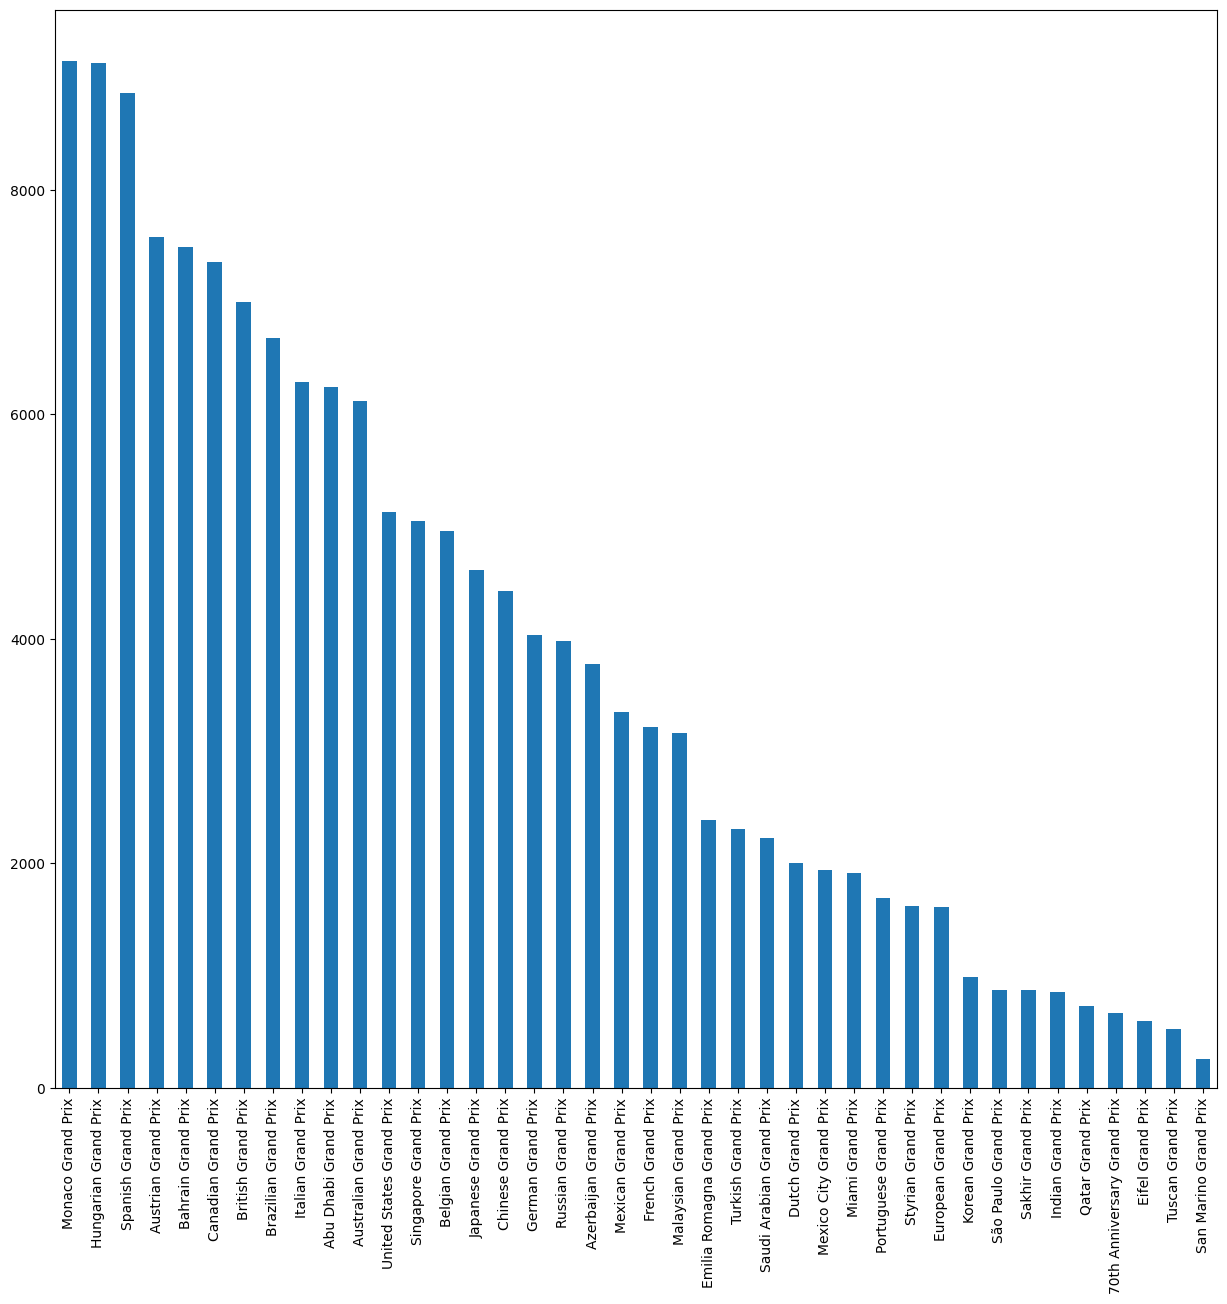

In [25]:
# Most number of races took place in Monaco
driver_race_laptimes_df["name"].value_counts().plot(kind = "bar", figsize = (15, 14))

In [26]:
driver_race_laptimes_df

,driverId,number,Name,raceId,lap,position,time,milliseconds,year,round,circuitId,name,date,race_start_time
0,1,44,Lewis Hamilton,841,1,2,1:40.573,100573,2011,1,1,Australian Grand Prix,2011-03-27,06:00:00
1,1,44,Lewis Hamilton,841,2,2,1:33.774,93774,2011,1,1,Australian Grand Prix,2011-03-27,06:00:00
2,1,44,Lewis Hamilton,841,3,2,1:32.900,92900,2011,1,1,Australian Grand Prix,2011-03-27,06:00:00
3,1,44,Lewis Hamilton,841,4,2,1:32.582,92582,2011,1,1,Australian Grand Prix,2011-03-27,06:00:00
4,1,44,Lewis Hamilton,841,5,2,1:32.471,92471,2011,1,1,Australian Grand Prix,2011-03-27,06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151582,858,2,Logan Sargeant,1110,40,18,1:52.082,112082,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00
151583,858,2,Logan Sargeant,1110,41,18,1:51.581,111581,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00
151584,858,2,Logan Sargeant,1110,42,18,1:52.364,112364,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00
151585,858,2,Logan Sargeant,1110,43,17,1:51.241,111241,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00


In [27]:
driver_race_laptimes_df.columns

Index(['driverId', 'number', 'Name', 'raceId', 'lap', 'position', 'time',
       'milliseconds', 'year', 'round', 'circuitId', 'name', 'date',
       'race_start_time'],
      dtype='object')

## Filter last 10 years

In [28]:
df_last10years= driver_race_laptimes_df[driver_race_laptimes_df["year"] >= 2013].reset_index(drop=True)
df_last10years

,driverId,number,Name,raceId,lap,position,time,milliseconds,year,round,circuitId,name,date,race_start_time
0,1,44,Lewis Hamilton,881,1,4,2:05.768,125768,2013,2,2,Malaysian Grand Prix,2013-03-24,08:00:00
1,1,44,Lewis Hamilton,881,2,3,1:57.796,117796,2013,2,2,Malaysian Grand Prix,2013-03-24,08:00:00
2,1,44,Lewis Hamilton,881,3,3,1:57.657,117657,2013,2,2,Malaysian Grand Prix,2013-03-24,08:00:00
3,1,44,Lewis Hamilton,881,4,3,1:57.743,117743,2013,2,2,Malaysian Grand Prix,2013-03-24,08:00:00
4,1,44,Lewis Hamilton,881,5,3,1:57.432,117432,2013,2,2,Malaysian Grand Prix,2013-03-24,08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129028,858,2,Logan Sargeant,1110,40,18,1:52.082,112082,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00
129029,858,2,Logan Sargeant,1110,41,18,1:51.581,111581,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00
129030,858,2,Logan Sargeant,1110,42,18,1:52.364,112364,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00
129031,858,2,Logan Sargeant,1110,43,17,1:51.241,111241,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00


## Convert lap times to seconds

In [29]:
# def lap_time_to_seconds(lap_time_str):
#     # Split the string into minutes and seconds
#     minutes, seconds = lap_time_str.split(':')
#     # Convert minutes to seconds and add to the seconds part
#     total_seconds = int(minutes) * 60 + float(seconds)
#     return total_seconds

def lap_time_to_seconds(lap_time_str):
    # Split the string based on the colon ':'
    parts = lap_time_str.split(':')

    # If there are three parts, it means there are hours, minutes, and seconds
    if len(parts) == 3:
        hours, minutes, seconds = parts
        total_seconds = int(hours) * 3600 + int(minutes) * 60 + float(seconds)
    # If there are two parts, it means there are only minutes and seconds
    elif len(parts) == 2:
        minutes, seconds = parts
        total_seconds = int(minutes) * 60 + float(seconds)
    else:
        raise ValueError("Invalid lap time format")

    return total_seconds


In [30]:
df_last10years.tail()

,driverId,number,Name,raceId,lap,position,time,milliseconds,year,round,circuitId,name,date,race_start_time
129028,858,2,Logan Sargeant,1110,40,18,1:52.082,112082,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00
129029,858,2,Logan Sargeant,1110,41,18,1:51.581,111581,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00
129030,858,2,Logan Sargeant,1110,42,18,1:52.364,112364,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00
129031,858,2,Logan Sargeant,1110,43,17,1:51.241,111241,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00
129032,858,2,Logan Sargeant,1110,44,17,1:52.590,112590,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00


In [31]:
df_last10years[df_last10years["time"] == "1:01:38.495"]

,driverId,number,Name,raceId,lap,position,time,milliseconds,year,round,circuitId,name,date,race_start_time
1517,1,44,Lewis Hamilton,908,2,4,1:01:38.495,3698495,2014,9,9,British Grand Prix,2014-07-06,12:00:00


## Anomalous time in lap 2

In [32]:
df_2014 = df_last10years[df_last10years["name"] == "British Grand Prix"]
df_2014 = df_2014[(df_2014["year"] == 2014) & (df_2014["driverId"] == 1)]
df_2014.head()

,driverId,number,Name,raceId,lap,position,time,milliseconds,year,round,circuitId,name,date,race_start_time
1516,1,44,Lewis Hamilton,908,1,4,2:19.816,139816,2014,9,9,British Grand Prix,2014-07-06,12:00:00
1517,1,44,Lewis Hamilton,908,2,4,1:01:38.495,3698495,2014,9,9,British Grand Prix,2014-07-06,12:00:00
1518,1,44,Lewis Hamilton,908,3,3,1:40.284,100284,2014,9,9,British Grand Prix,2014-07-06,12:00:00
1519,1,44,Lewis Hamilton,908,4,2,1:39.533,99533,2014,9,9,British Grand Prix,2014-07-06,12:00:00
1520,1,44,Lewis Hamilton,908,5,2,1:39.345,99345,2014,9,9,British Grand Prix,2014-07-06,12:00:00


In [33]:
# Quick fix - use the new function instead of replacing
df_lapreplace = df_last10years.copy()
# df_lapreplace["time"] = df_lapreplace["time"].replace("1:01:38.495", "2:19.816")

## Convert to seconds

In [34]:
df_lapreplace["time_in_seconds"] = df_lapreplace["time"].apply(lambda x : lap_time_to_seconds(x))

## Create the dataset, for every driver and every race, take the first 5 lap times and a moving window to predict for the 6th lap time

In [35]:
df_lapreplace.head(7)

,driverId,number,Name,raceId,lap,position,time,milliseconds,year,round,circuitId,name,date,race_start_time,time_in_seconds
0,1,44,Lewis Hamilton,881,1,4,2:05.768,125768,2013,2,2,Malaysian Grand Prix,2013-03-24,08:00:00,125.768
1,1,44,Lewis Hamilton,881,2,3,1:57.796,117796,2013,2,2,Malaysian Grand Prix,2013-03-24,08:00:00,117.796
2,1,44,Lewis Hamilton,881,3,3,1:57.657,117657,2013,2,2,Malaysian Grand Prix,2013-03-24,08:00:00,117.657
3,1,44,Lewis Hamilton,881,4,3,1:57.743,117743,2013,2,2,Malaysian Grand Prix,2013-03-24,08:00:00,117.743
4,1,44,Lewis Hamilton,881,5,3,1:57.432,117432,2013,2,2,Malaysian Grand Prix,2013-03-24,08:00:00,117.432
5,1,44,Lewis Hamilton,881,6,2,1:56.590,116590,2013,2,2,Malaysian Grand Prix,2013-03-24,08:00:00,116.590
6,1,44,Lewis Hamilton,881,7,3,1:58.733,118733,2013,2,2,Malaysian Grand Prix,2013-03-24,08:00:00,118.733


## Univariate dataset creation - only on lap times - per driver per race

In [36]:
# Function to create dataset for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Selecting relevant features for the model
features = ['time_in_seconds']  # Add more features as needed
df_selected = df_lapreplace[features].copy()

# We will predict 'time' based on previous 5 laps
time_steps = 5
# X, y = create_dataset(df_selected, df_selected['time_in_seconds'], time_steps)

In [37]:
grouped = df_lapreplace.groupby(['raceId', 'driverId'])

# Initialize empty lists to hold the grouped data
X_all, y_all = [], []

for name, group in grouped:
    # Selecting relevant features for the model
    # The group is for each race eg Australian grand prix, the lap times of a single driver
    features = ['time_in_seconds']
    df_selected = group[features].copy()

    # Apply the create_dataset function to each group
    time_steps = 5
    X, y = create_dataset(df_selected, df_selected['time_in_seconds'], time_steps)

    X_all.append(X)
    y_all.append(y)

In [38]:
len(X_all), len(y_all)

(2317, 2317)

In [39]:
# Number of laps, timesteps, number of features format
for i in X_all:
  print(i.shape)
  break

(53, 5, 1)


## Split the data

In [40]:
## Ensure all arrays are 3 dimensional for LSTM
consistent_X_all = [array for array in X_all if array.ndim == 3]

# Then concatenate
X_all_combined = np.concatenate(consistent_X_all, axis=0)
y_all_combined = np.concatenate(y_all, axis=0)

In [41]:
X_all_combined.shape, y_all_combined.shape

((117581, 5, 1), (117581,))

In [42]:
# Concatenate to form a single array
# X_all_combined = np.concatenate(X_all, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X_all_combined, y_all_combined, test_size=0.15, random_state=42)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((99943, 5, 1), (17638, 5, 1), (99943,), (17638,))

In [44]:
# Normalizing features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


# Training the model
# model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# Predicting and evaluating the model
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

## Create the LSTM model

In [44]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(5, 1)))  # 50 units, input_shape = (time_steps, features)
model.add(Dense(1))  # Output layer with 1 unit for regression

In [45]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/30
1562/1562 [==============================] - 15s 9ms/step - loss: 2962.7178 - val_loss: 2249.8423
Epoch 2/30
1562/1562 [==============================] - 14s 9ms/step - loss: 2943.0469 - val_loss: 2233.3125
Epoch 3/30
1562/1562 [==============================] - 15s 9ms/step - loss: 2932.7673 - val_loss: 2170.0249
Epoch 4/30
1562/1562 [==============================] - 14s 9ms/step - loss: 2925.5344 - val_loss: 2335.4675
Epoch 5/30
1562/1562 [==============================] - 14s 9ms/step - loss: 2979.0308 - val_loss: 2211.5996
Epoch 6/30
1562/1562 [==============================] - 14s 9ms/step - loss: 2943.1067 - val_loss: 2159.5095
Epoch 7/30
1562/1562 [==============================] - 14s 9ms/step - loss: 2904.5613 - val_loss: 2173.4011
Epoch 8/30
1562/1562 [==============================] - 14s 9ms/step - loss: 2865.2371 - val_loss: 2154.3030
Epoch 9/30
1562/1562 [==============================] - 14s 9ms/step - loss: 2883.7246 - val_loss: 2407.4951
Epoch 10/30
1562/15

In [54]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

552/552 [==============================] - 1s 3ms/step - loss: 2258.0779
Test Loss: 2258.077880859375


In [55]:
X_test.shape

(17638, 5, 1)

In [56]:
# Get predictions
y_pred = model.predict(X_test)

# y_pred is now an array of predictions corresponding to X_test


# Example: Print the first 10 actual vs predicted values
for i in range(10):
    print(f"Actual: {y_test[i]}, Predicted: {y_pred[i][0]}")


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# These metrics give you a numerical indication of the model's performance.

552/552 [==============================] - 2s 2ms/step
Actual: 80.291, Predicted: 82.18439483642578
Actual: 80.57, Predicted: 81.45850372314453
Actual: 69.18299999999999, Predicted: 70.7270736694336
Actual: 101.858, Predicted: 91.9857406616211
Actual: 82.777, Predicted: 85.35478973388672
Actual: 81.424, Predicted: 83.30289459228516
Actual: 84.102, Predicted: 86.53826904296875
Actual: 83.624, Predicted: 86.11273193359375
Actual: 125.118, Predicted: 157.63111877441406
Actual: 79.581, Predicted: 82.01631927490234
Mean Absolute Error: 7.482569665787914
Mean Squared Error: 2258.0779667766674
